In [1]:
import sys 
sys.path.append('..')
from Data import gener_dt
from Tools import MI, Imputers, Metrics, HG_tools

import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import pyampute
from pyampute.ampute import MultivariateAmputation

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline
from importlib import reload
import os

In [2]:
reload(Imputers)
reload(MI)
reload(gener_dt)
reload(Metrics)
reload(HG_tools)

<module 'Tools.HG_tools' from '/Users/ash/Desktop/MICE/PY/HG_ice_mice/../Tools/HG_tools.py'>

In [3]:
distrs = ['norm', 'unif', 'lognorm1', 'lognorm2', 'gamma1', 'gamma2', 'norm_mix1', 'norm_mix2']

In [4]:
def cust_plot(regr_type, dist, df, var_labels):
   
    fig, ax = plt.subplots(1, 1, figsize = (18, 9), sharex = True, sharey = True ) #figsize = (26, 16)
    xs = 5 * np.array(range(len(var_labels)))
    
    ax.errorbar(x = xs, y = df[df['estimator'] == 'original']['coefs'][0], yerr = df[df['estimator'] == 'original']['conf_int'][0], fmt = 'o', capsize=4)
    ax.errorbar(x = xs + 1, y = df[df['estimator'] == 'ice_rf']['coefs'][0], yerr = df[df['estimator'] == 'ice_rf']['conf_int'][0], fmt = 'o', capsize=4)
    ax.errorbar(x = xs + 2, y = df[df['estimator'] == 'mice_rf']['coefs'][0], yerr = df[df['estimator'] == 'mice_rf']['conf_int'][0], fmt = 'o', capsize=4)    
    ax.errorbar(x = xs + 3, y = df[df['estimator'] == 'knn']['coefs'][0], yerr = df[df['estimator'] == 'knn']['conf_int'][0], fmt = 'o', capsize=4) 

    matplotlib.rcParams.update({'font.size': 20})
    plt.legend(['original', 'ice_rf', 'mice_rf', 'knn'], prop={"size": 20})

    ax.set_xticks(xs.astype(int) + 1, minor = False)
    ax.set_xticklabels(var_labels)
    
    # Set tick font size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)
        
    if regr_type == 'lin_regr':
        regr_lbl = 'Лин.регр.'
    else:
        regr_lbl = 'Лог.регр.'

    ax.set_title(str(regr_lbl) + " Коэффициенты + доверит. интервал. X ~ " + str(dist))

Coefficients after usage only methods only once (here we have to see difference between ICE and MICE)

In [5]:
def coefs_one_imp(scenar, dist): 
    
    metrica = 'relb_coef'
    
    if scenar in ['lr_quadr', 'logr_quadr']:
        col2 = "X^2"
    else:
        col2 = "XZ"
        
        
    if scenar in ['lr_quadr', 'lr_inter']:
        regr_type = 'lin_regr'
    elif scenar in ['logr_quadr', 'logr_inter']:
        regr_type = 'log_regr'
    
    
    df_fin = pd.DataFrame(columns = ['dist', 'estimator', 'coefs', 'conf_int'])
    # for dist in distrs:

    df = gener_dt.gener(X_distr = dist, scenar = scenar)

    df_coefs, df_ses = MI.coefs_vars(df, regr_type)
    df_conf_int = 2 * df_ses 
    df_fin = pd.concat([df_fin, 
                  pd.DataFrame.from_records([{'dist':dist, 'estimator':'original', 'coefs': df_coefs, 'conf_int':df_conf_int}])])

    X_miss = HG_tools.amp(df)

    #iceRF
    #---------------------------
    ice_imp = Imputers.impute(X_miss, 'ice_rf')
    ice_coefs, ice_ses = MI.coefs_vars(ice_imp, regr_type)
    ice_conf_int = 2 * ice_ses
    df_fin = pd.concat([df_fin, 
          pd.DataFrame.from_records([{'dist':dist, 'estimator':'ice_rf', 'coefs': ice_coefs, 'conf_int':ice_conf_int}])])

    #miceRF
    #---------------------------
    mice_imp = Imputers.impute(X_miss, 'mice_rf')
    mice_coefs, mice_ses = MI.pooling(mice_imp, regr_type)
    mice_conf_int = 2 * mice_ses
    df_fin = pd.concat([df_fin, 
          pd.DataFrame.from_records([{'dist':dist, 'estimator':'mice_rf', 'coefs': mice_coefs, 'conf_int':mice_conf_int}])])


    #knn
    #---------------------------
    knn_imp = Imputers.impute(X_miss, 'knn')
    knn_coefs, knn_ses = MI.coefs_vars(knn_imp, regr_type)
    knn_conf_int = 2 * knn_ses
    df_fin = pd.concat([df_fin, 
          pd.DataFrame.from_records([{'dist':dist, 'estimator':'knn', 'coefs': knn_coefs, 'conf_int':knn_conf_int}])])

    if scenar in ['lr_quadr', 'logr_quadr']:
        cust_plot(regr_type, dist, df_fin, ['interc.', 'X', 'X^2'])
    else: cust_plot(regr_type, dist, df_fin, ['interc.', 'X', 'XZ', 'Z'])
    
    return df_fin

In [241]:
['lr_quadr', 'logr_quadr', 'lr_inter', 'logr_inter']
distrs = ['norm', 'unif', 'lognorm1', 'lognorm2', 'gamma1', 'gamma2', 'norm_mix1', 'norm_mix2']

# Линрегр lognorm1

На сл.  2x графиках можно увидеть преимущество Mice относительно ICE

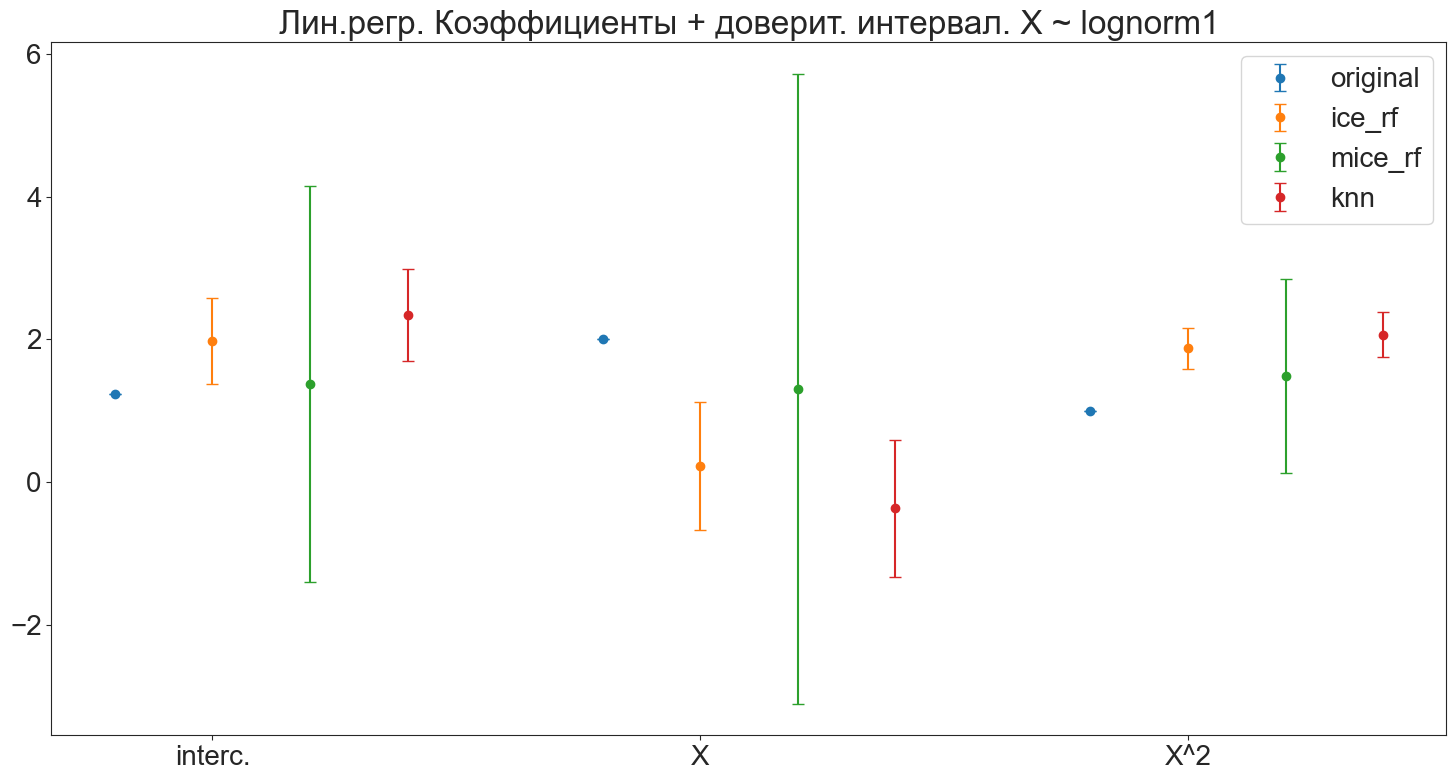

In [209]:
coefs_one_imp('lr_quadr', 'lognorm1')
plt.savefig('mice_bett.png')

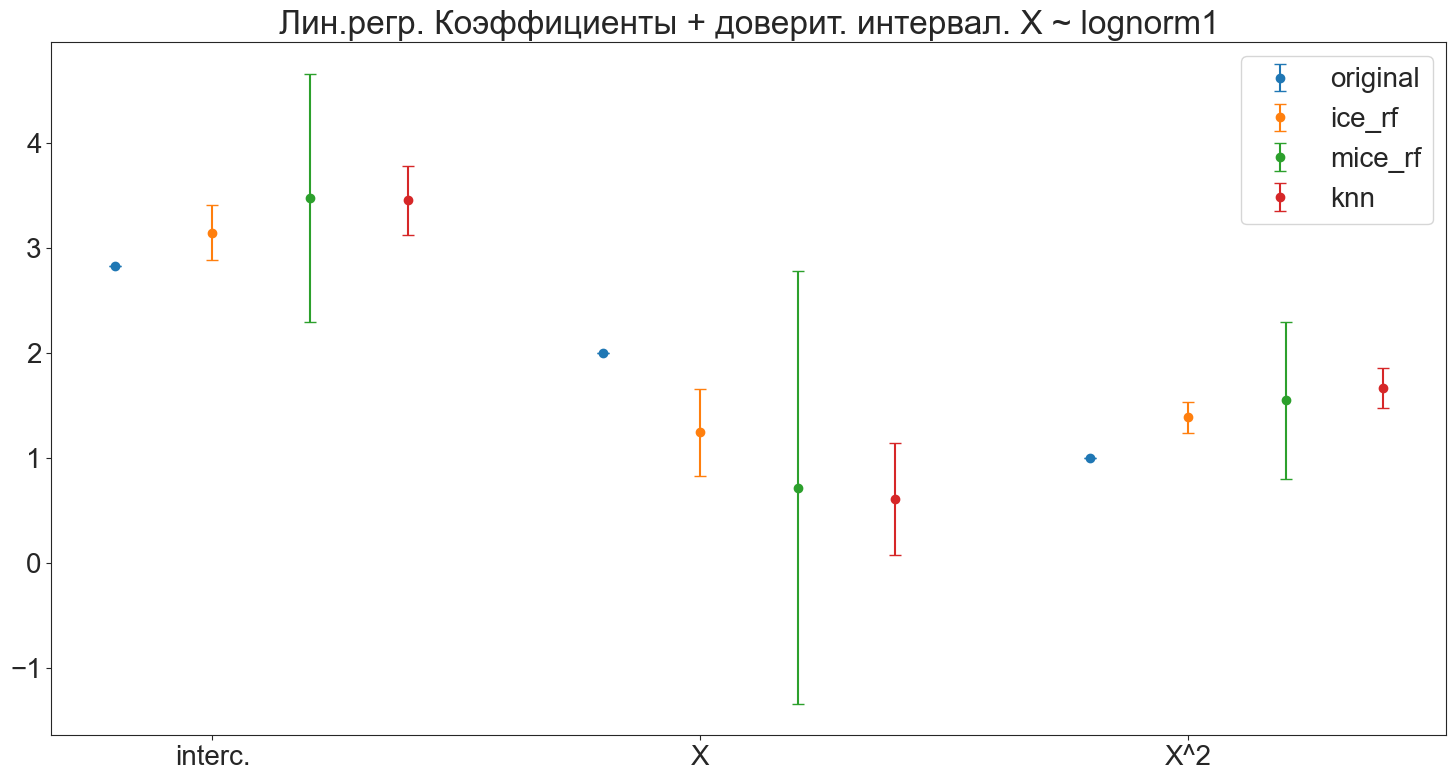

In [210]:
coefs_one_imp('lr_quadr', 'lognorm1')
plt.savefig('mice_bett2.png')

тем не менее может быть так: (видимо, в mice оказались 5 похожих заполнения)

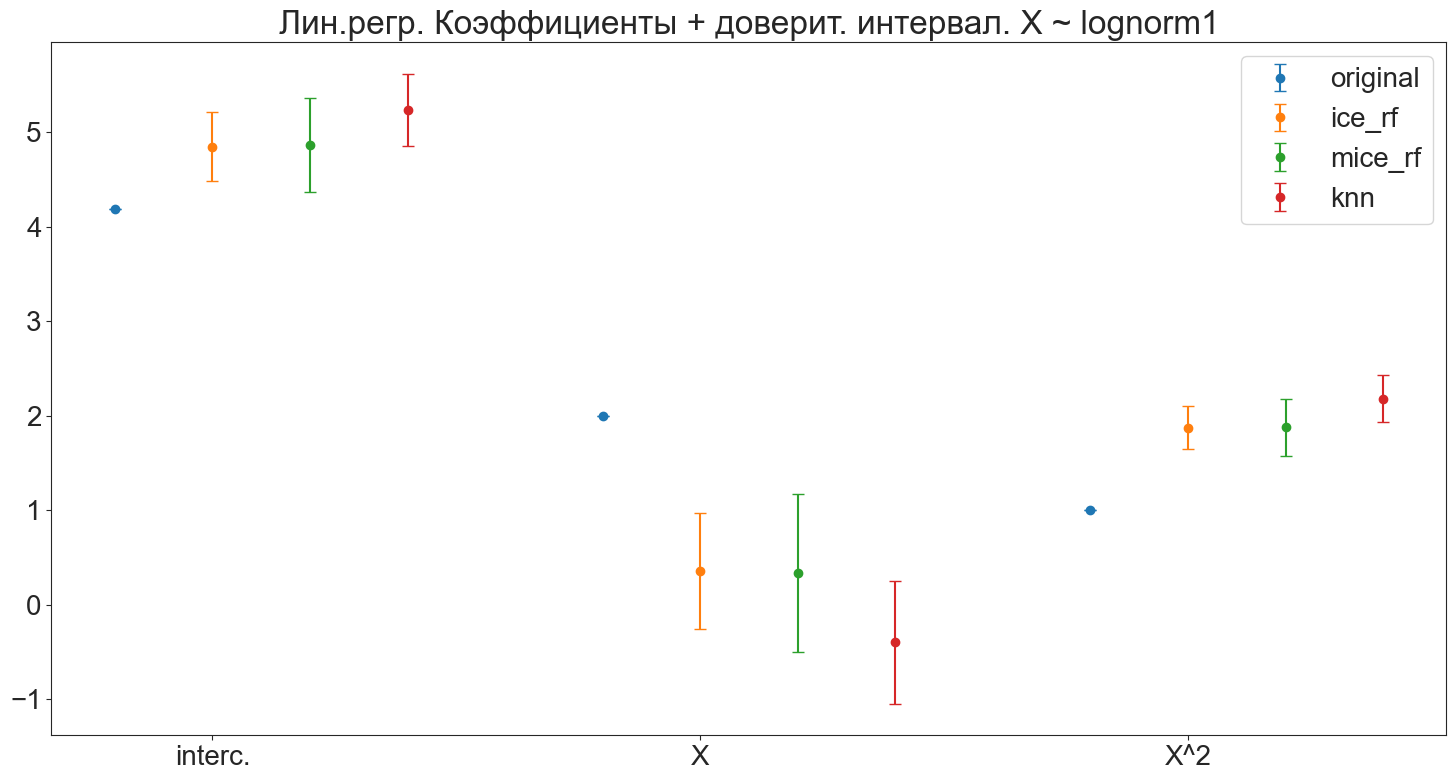

In [211]:
coefs_one_imp('lr_quadr', 'lognorm1')
plt.savefig('ice_mice_bed.png')

тоже наблюдение про то, что у майса больше вариация. вот пример того, что ice в этот раз попал

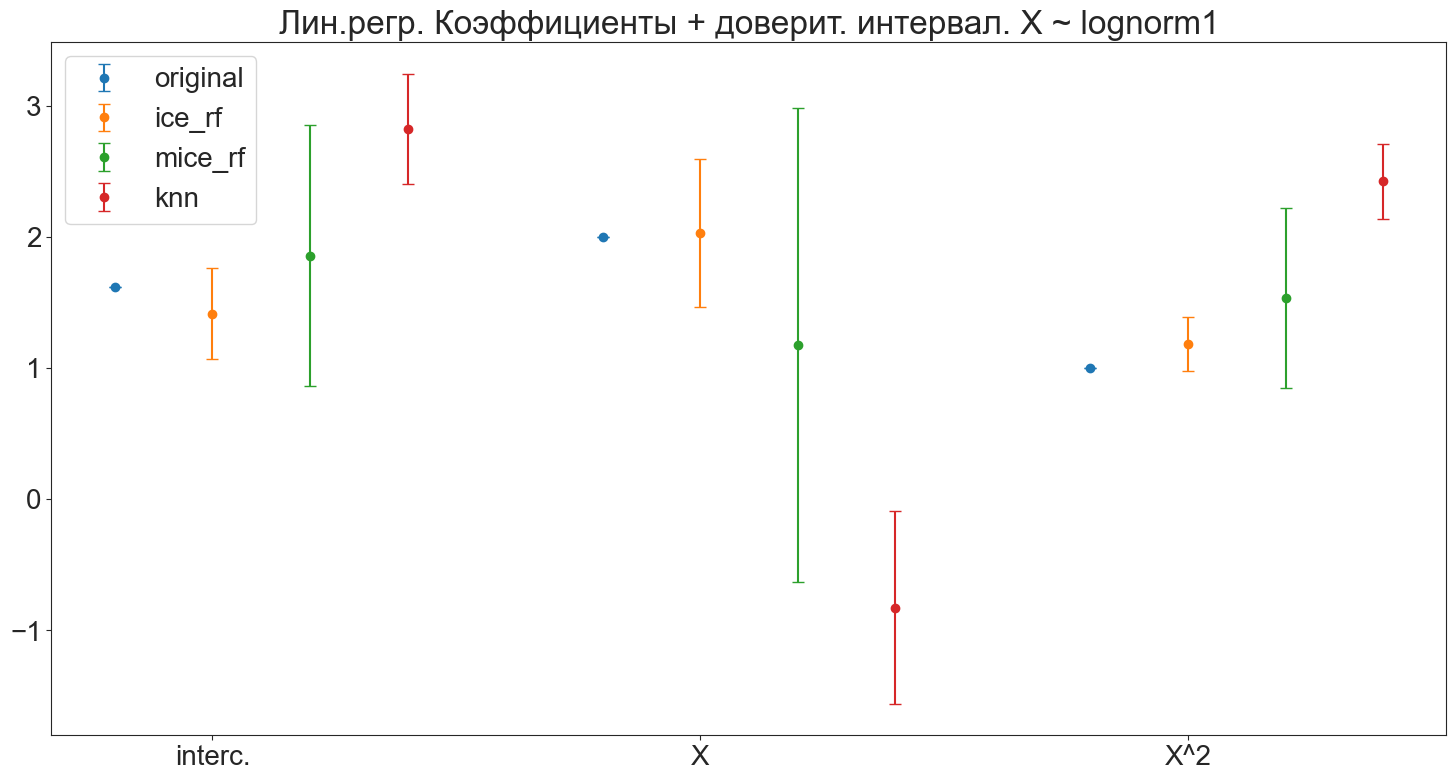

In [215]:
coefs_one_imp('lr_quadr', 'lognorm1')
plt.savefig('ice_mice_good.png')

ice круто попал в interc, но в X, X2 сработал mice

In [234]:
#coefs_one_imp('lr_quadr', 'lognorm1')
#plt.savefig('ice_middle.png')

# Ivanovo

In [6]:
def cust_plot(df, var_labels, mice_labels):
   
    fig, ax = plt.subplots(1, 1, figsize = (18, 9), sharex = True, sharey = True ) #figsize = (26, 16)
    xs = 5 * np.array(range(len(var_labels)))
    
    ax.errorbar(x = xs, y = df[df['estimator'] == 'original']['coefs'][0][var_labels], yerr = df[df['estimator'] == 'original']['conf_int'][0][var_labels], fmt = 'o', capsize=4)
    ax.errorbar(x = xs + 1, y = df[df['estimator'] == 'ice_rf']['coefs'][0][var_labels], yerr = df[df['estimator'] == 'ice_rf']['conf_int'][0][var_labels], fmt = 'o', capsize=4)
    ax.errorbar(x = xs + 2, y = df[df['estimator'] == 'mice_rf']['coefs'][0][mice_labels], yerr = df[df['estimator'] == 'mice_rf']['conf_int'][0][mice_labels], fmt = 'o', capsize=4)    
    ax.errorbar(x = xs + 3, y = df[df['estimator'] == 'knn']['coefs'][0][var_labels], yerr = df[df['estimator'] == 'knn']['conf_int'][0][var_labels], fmt = 'o', capsize=4) 

    matplotlib.rcParams.update({'font.size': 20})
    plt.legend(['original', 'ice_rf', 'mice_rf', 'knn'], prop={"size": 20})

    ax.set_xticks(xs.astype(int) + 1, minor = False)
    ax.set_xticklabels(var_labels)
    
    # Set tick font size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

    ax.set_title("Реальные данные. MAR. Коэффициенты + доверит. интервал")

In [7]:
def coefs_one_imp(df, varss): 
    
    metrica = 'relb_coef'
    scenar = 'lr_quadr'
    regr_type = 'lin_regr'
    
    
    df_fin = pd.DataFrame(columns = ['estimator', 'coefs', 'conf_int'])
    
    ma = MultivariateAmputation( #, 'weights': weis
            patterns = [ {'incomplete_vars': varss, 'mechanism': 'MAR', 'score_to_probability_func': 'sigmoid-right'} ],
            prop = 0.35
            )
    X_miss = ma.fit_transform(df_dropna)
    

    
    df_coefs, df_ses = MI.coefs_vars(df_dropna, regr_type)
    df_conf_int = 2 * df_ses 
    df_fin = pd.concat([df_fin, 
                  pd.DataFrame.from_records([{'estimator':'original', 'coefs': df_coefs, 'conf_int':df_conf_int}])])


    #iceRF
    #---------------------------
    ice_imp = Imputers.impute(X_miss, 'ice_rf')
    ice_coefs, ice_ses = MI.coefs_vars(ice_imp, regr_type)
    ice_conf_int = 2 * ice_ses
    df_fin = pd.concat([df_fin, 
          pd.DataFrame.from_records([{'estimator':'ice_rf', 'coefs': ice_coefs, 'conf_int':ice_conf_int}])])

    #miceRF
    #---------------------------
    mice_imp = Imputers.impute(X_miss, 'mice_rf')
    mice_coefs, mice_ses = MI.pooling(mice_imp, regr_type)
    mice_conf_int = 2 * mice_ses
    df_fin = pd.concat([df_fin, 
          pd.DataFrame.from_records([{'estimator':'mice_rf', 'coefs': mice_coefs, 'conf_int':mice_conf_int}])])


    #knn
    #---------------------------
    knn_imp = Imputers.impute(X_miss, 'knn')
    knn_coefs, knn_ses = MI.coefs_vars(knn_imp, regr_type)
    knn_conf_int = 2 * knn_ses
    df_fin = pd.concat([df_fin, 
          pd.DataFrame.from_records([{'estimator':'knn', 'coefs': knn_coefs, 'conf_int':knn_conf_int}])])

    #cust_plot(regr_type, dist, df_fin, ['interc.', 'X', 'XZ', 'Z'])
    
    return df_fin

In [8]:
X_full = np.genfromtxt(os.path.basename('/Users/ash/Desktop/MICE/PY/data_ivanovo.csv') , delimiter=';', skip_header=2)
df = pd.DataFrame(X_full, columns = [str(i) for i in range(X_full.shape[1])])
df = df.rename(columns = {'2':'X'})
df_dropna = df.dropna(axis=0)
df_dropna = df_dropna.rename(columns = {'17':'Y'})

FileNotFoundError: data_ivanovo.csv not found.

In [357]:
#MAR 0.35
vars_all = [5, 12, 13, 14, 15, 16]
tmp_035 = coefs_one_imp(df_dropna, vars_all)

2023-03-29 21:36:51,723 [WARNING] Binary variables (at indices [0 2 3 4]) are indicated to be used in amputation (they are weighted and will be used to calculate the weighted sum score under MAR, MNAR, or MAR+MNAR). This can result in a subset with candidates that all have the same (or almost the same) weighted sum scores. 


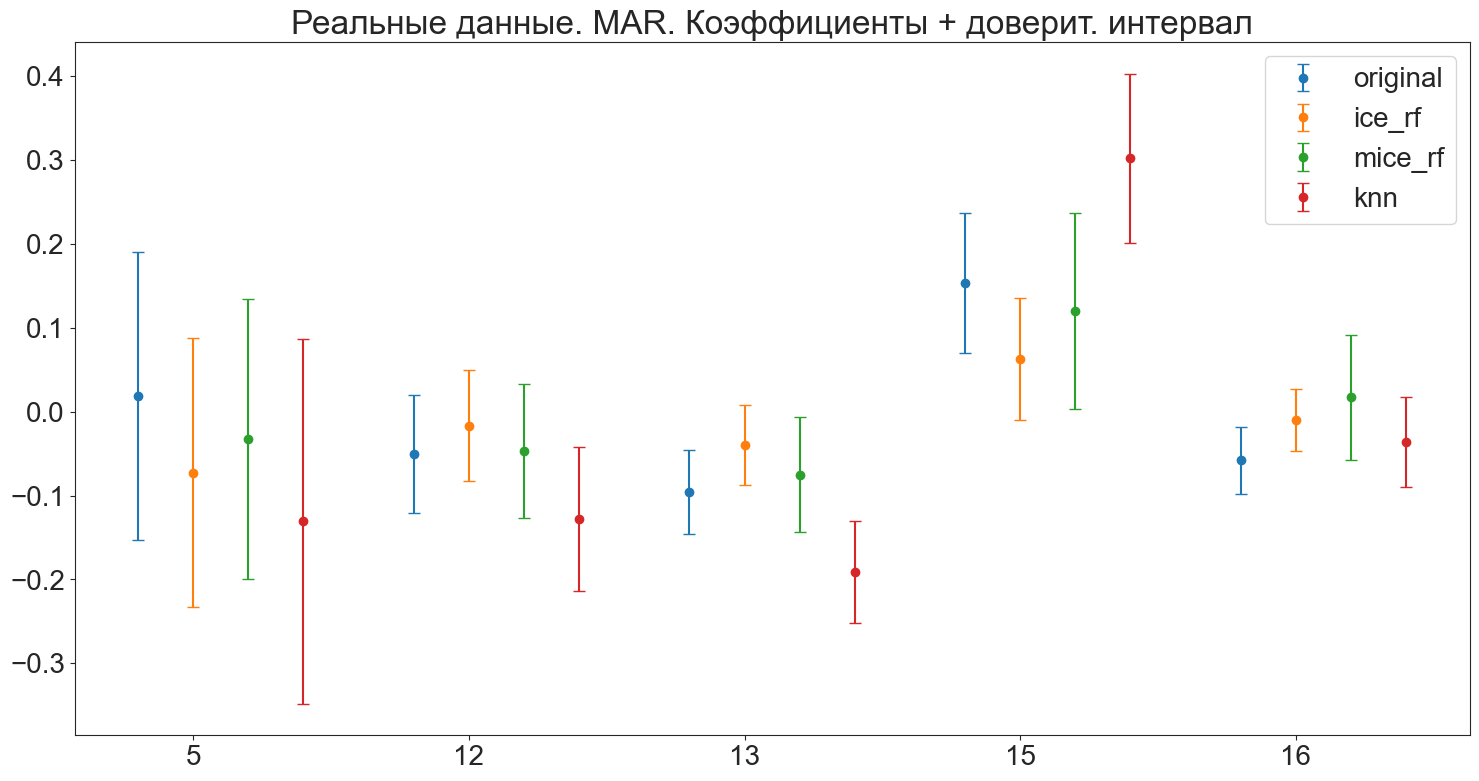

In [364]:
var_lbl = ['5', '12', '13', '15', '16']
mice_lbl = [6, 13, 14, 16, 17]
cust_plot(tmp, var_lbl, mice_lbl)

plt.savefig('/Users/ash/Desktop/MICE/Diploma_pict/HG_PY_R/Iv_coef_vars.pdf')

In [326]:
#vars_all = [10, 14, 16]
vars_all = [5, 12, 13, 14, 15, 16]
tmp = coefs_one_imp(df_dropna, vars_all)

2023-03-29 21:14:56,412 [WARNING] Binary variables (at indices [0 2 3 4]) are indicated to be used in amputation (they are weighted and will be used to calculate the weighted sum score under MAR, MNAR, or MAR+MNAR). This can result in a subset with candidates that all have the same (or almost the same) weighted sum scores. 


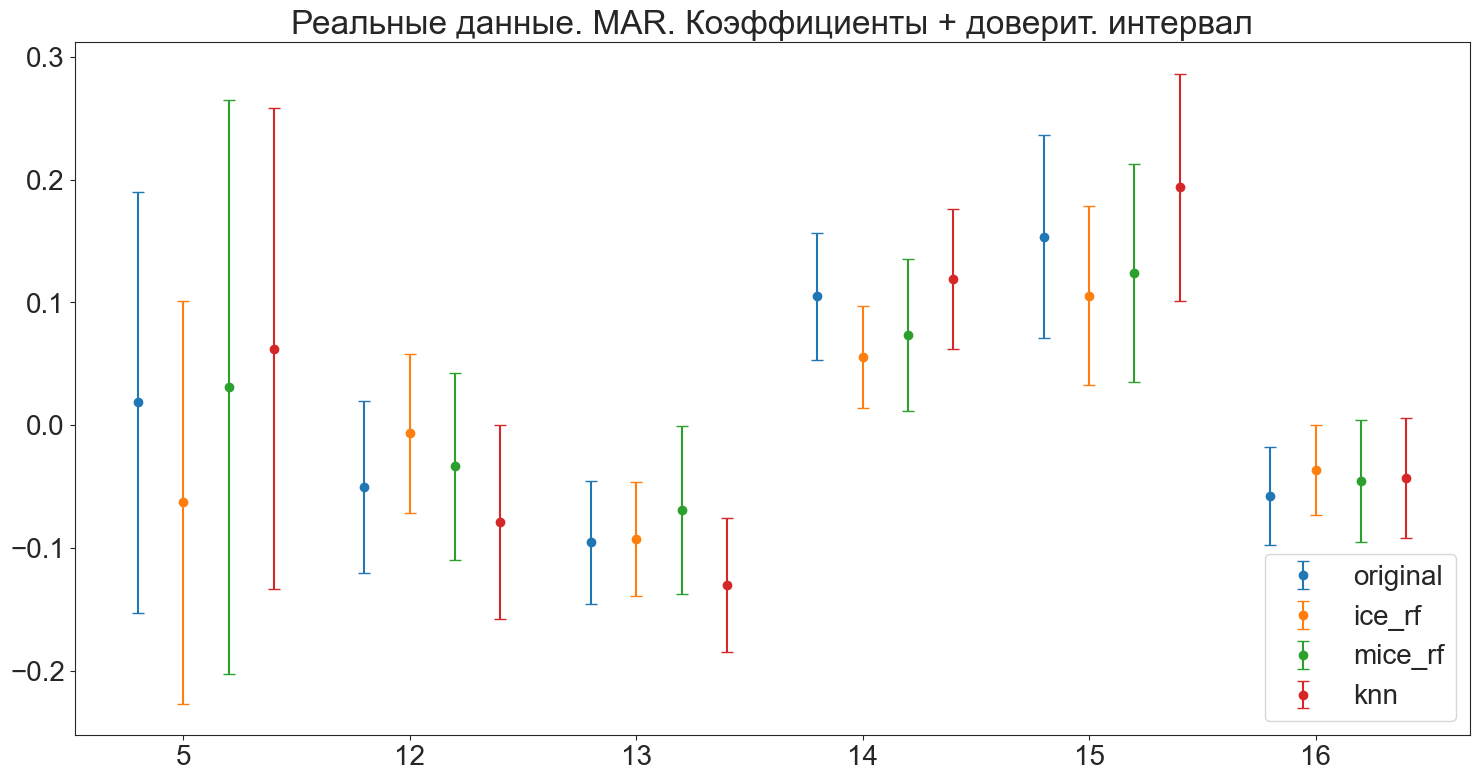

In [354]:
#var_lbl = ['const', '12', '14', '16']
var_lbl = ['5', '12', '13', '14', '15', '16']
mice_lbl = [6, 13, 14, 15, 16, 17]
cust_plot(tmp, var_lbl, mice_lbl)

In [337]:
vars_10 = [10]

tmp_10 = coefs_one_imp(df_dropna, vars_10)

2023-03-29 21:21:29,126 [WARNING] Binary variables (at indices [0 2 3 4 5]) are indicated to be used in amputation (they are weighted and will be used to calculate the weighted sum score under MAR, MNAR, or MAR+MNAR). This can result in a subset with candidates that all have the same (or almost the same) weighted sum scores. 


In [345]:
tmp_10[tmp_10['estimator'] == 'original']['coefs'][0]

const    1.459162
0       -0.890102
1       -0.032192
X       -0.009346
3       -0.019550
4        0.167882
5        0.018535
6       -0.142811
7        0.180276
8        0.105685
9        0.047810
10       0.024886
11       0.012252
12      -0.050471
13      -0.095329
14       0.105013
15       0.153635
16      -0.057787
dtype: float64

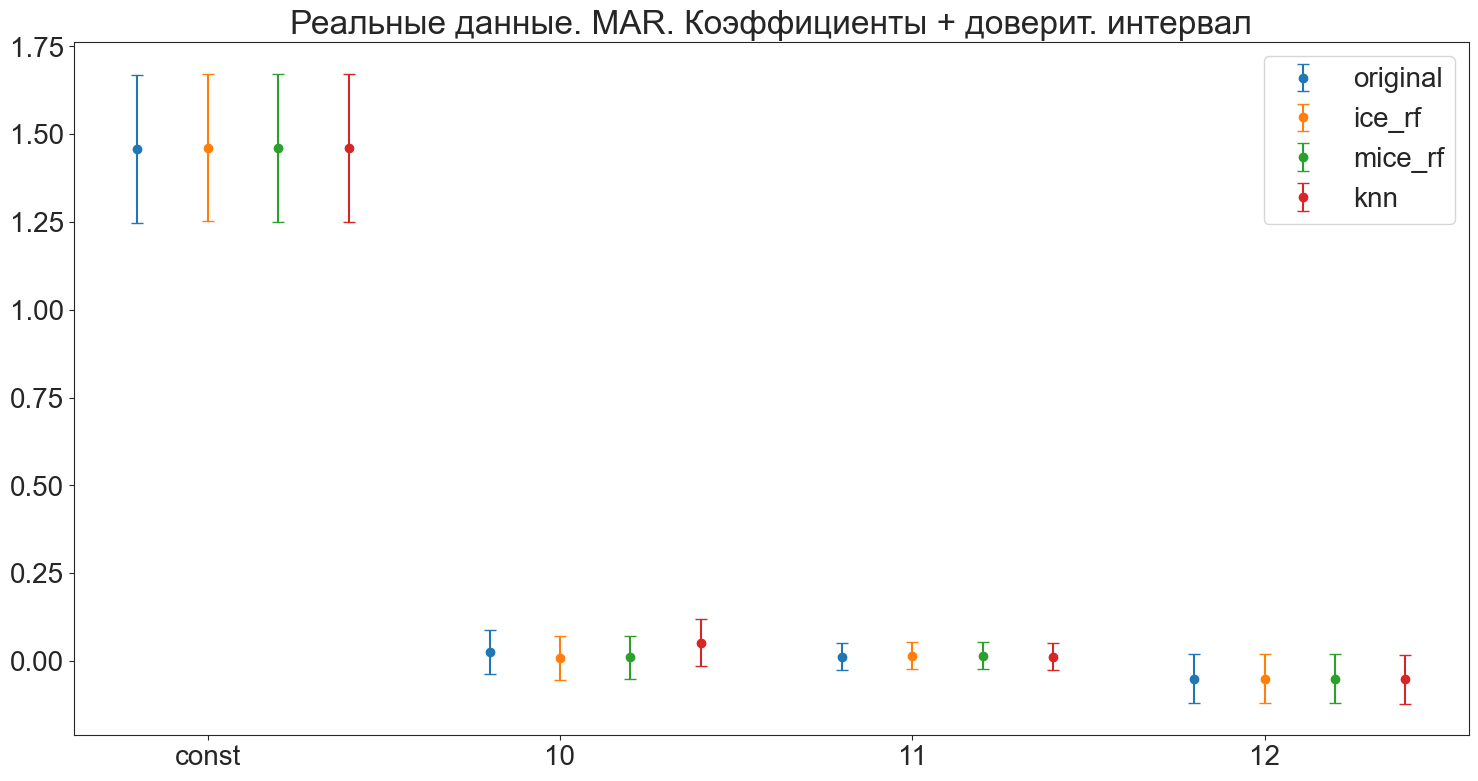

In [349]:
var_10_lbl = ['const', '10', '11', '12']
mice_10_lbl = [0, 11, 12, 13]
cust_plot(tmp_10, var_10_lbl, mice_10_lbl)

In [342]:
tmp[tmp['estimator'] == 'mice_rf']['coefs'][0]

array([ 1.43554085, -0.88593003, -0.02273391, -0.02542674, -0.0207926 ,
        0.16588817,  0.03098577, -0.14379356,  0.170174  ,  0.13116143,
        0.04601437,  0.02342552,  0.00851999, -0.03352355, -0.06907838,
        0.07373978,  0.12401003, -0.0453034 ])

In [295]:
#tmp[tmp['estimator'] == 'mice_rf']['coefs'][0][[0, 13, 14, 15]]

array([-0.91082634, -0.00874256, -0.00452869, -0.04551187])

# в случае логрегра все плохо. не понятно! Исправила!:)


2023-03-27 01:08:58,021 [WARNING] Indicated weights for incomplete vars for a pattern with MAR. Did you mean MAR+MNAR?
2023-03-27 01:08:58,023 [WARNING] Binary variables (at indices [1]) are indicated to be used in amputation (they are weighted and will be used to calculate the weighted sum score under MAR, MNAR, or MAR+MNAR). This can result in a subset with candidates that all have the same (or almost the same) weighted sum scores. 
2023-03-27 01:08:58,027 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.


,dist,estimator,coefs,conf_int
0,lognorm1,original,const -1.537516 X 0.017976 XZ 0...,const 0.716570 X 0.583973 XZ 0...
0,lognorm1,ice_rf,const -1.708063 X 0.156394 XZ 0...,const 0.715692 X 0.559756 XZ 0...
0,lognorm1,mice_rf,"[-1.6090827960444531, 0.06700486324107198, 0.0...","[0.7225004860815493, 0.5668660250087725, 0.124..."
0,lognorm1,knn,const -1.404040 X -0.096703 XZ 0...,const 0.766408 X 0.632328 XZ 0...


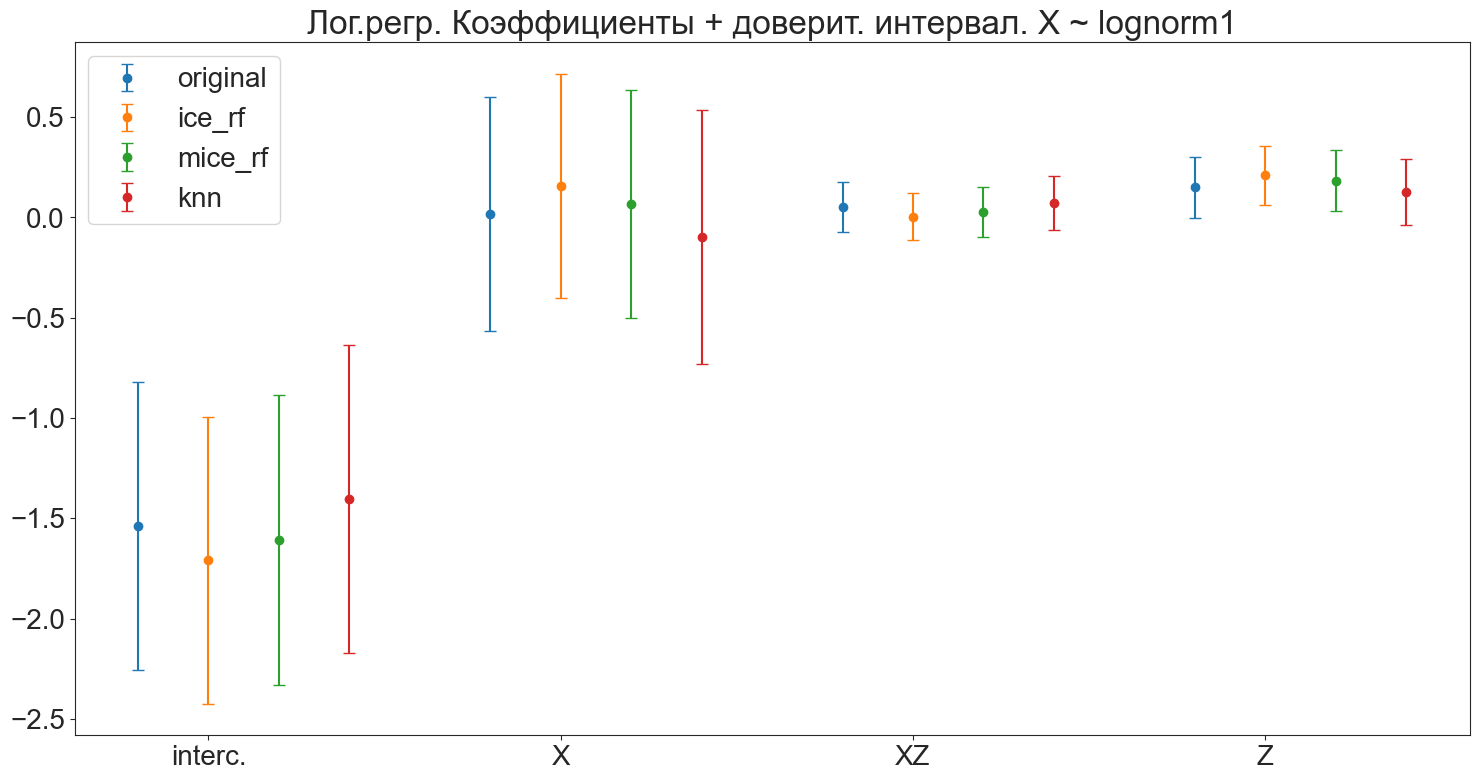

In [245]:
coefs_one_imp('logr_inter', 'lognorm1')

2023-03-27 12:27:03,873 [WARNING] Indicated weights for incomplete vars for a pattern with MAR. Did you mean MAR+MNAR?
2023-03-27 12:27:03,874 [WARNING] Binary variables (at indices [1]) are indicated to be used in amputation (they are weighted and will be used to calculate the weighted sum score under MAR, MNAR, or MAR+MNAR). This can result in a subset with candidates that all have the same (or almost the same) weighted sum scores. 
2023-03-27 12:27:03,879 [WARNING] Candidates for pattern 0 all have almost the same weighted sum scores. It is possible this is due to the use of binary variables in amputation. This creates problems when using the sigmoid function for the score_to_probability_func. Currently our solution is as follows: if there is just one candidate with a sum score 0, we will ampute it. If there is one candidate with a nonzero sum score, or multiple candidates with the same score, we evenly apply as if MCAR.


,dist,estimator,coefs,conf_int
0,lognorm1,original,const -1.622631 X 0.465545 XZ -0...,const 0.687830 X 0.527544 XZ 0...
0,lognorm1,ice_rf,const -1.391585 X 0.237047 XZ 0...,const 0.685045 X 0.528900 XZ 0...
0,lognorm1,mice_rf,"[-1.4030906896088573, 0.2476964385088575, 0.04...","[0.7305831670059241, 0.573299475588825, 0.1266..."
0,lognorm1,knn,const -1.638893 X 0.482111 XZ 0...,const 0.732526 X 0.570883 XZ 0...


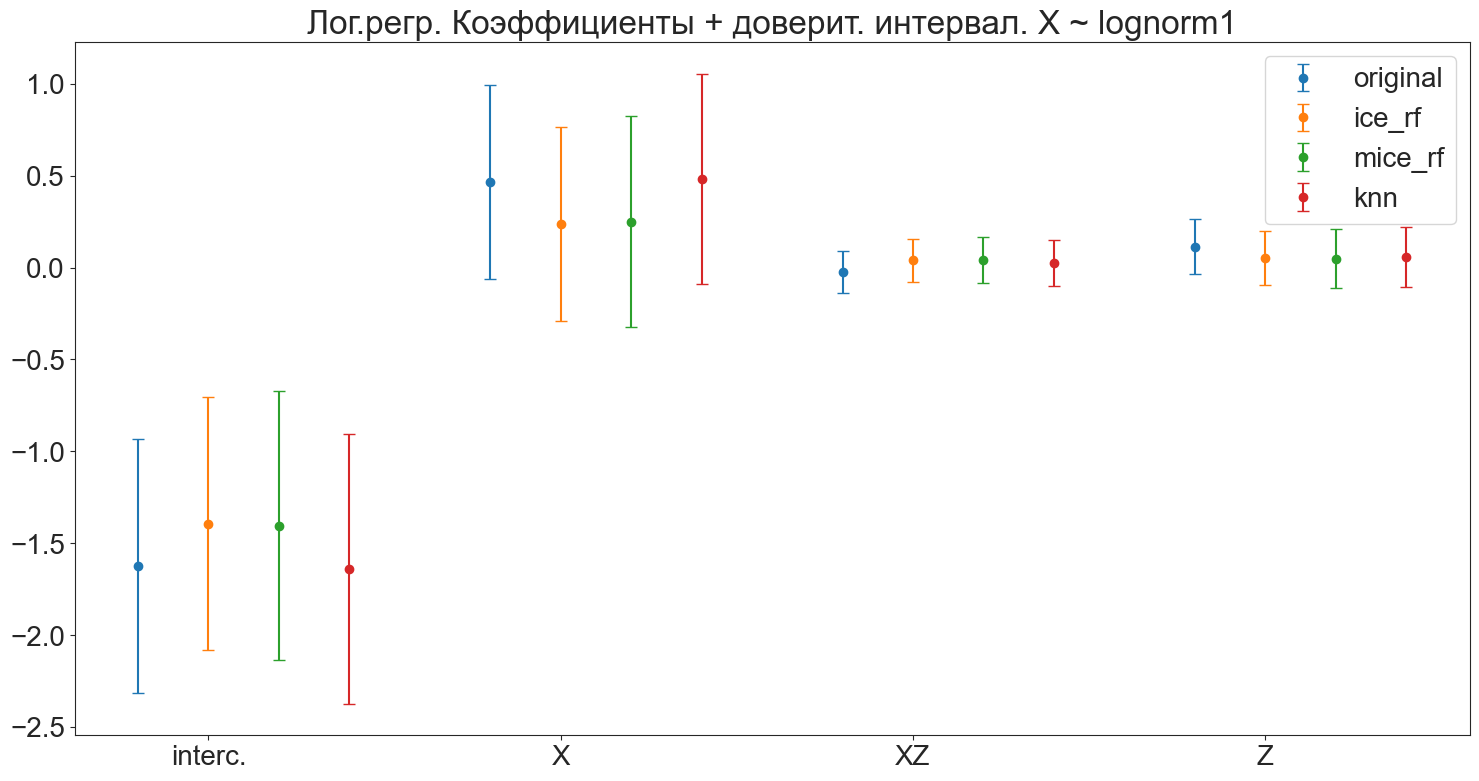

In [254]:
coefs_one_imp('logr_inter', 'lognorm1')